# 2-2_CNN_Advanced

### LeNet
LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to lenet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing.
* paper: http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

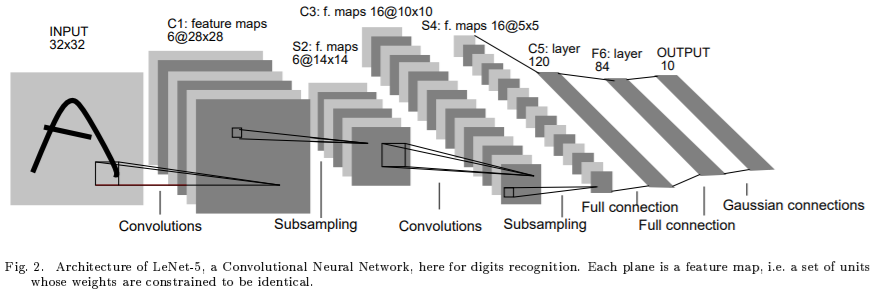

Description
* input: 32x32 pixel image / database는 28x28인데, 이를 center로 모아주기 위하여 다소 크게 만듬
* C1: conv2d(1, 6, kernel=5)과 동일
* S2: avg_pool2d(kernel=2) + 각 픽셀별 add+bias + sigmoid
* C3: conv2d(6, 16, kernel=5)과 동일
* S4: S2와 거의 동일
* C5: conv2d(16, 120, kernel=5)
* F6: Linear(120, 84)
* activation: hyperbolic tangent function


### AlexNet

AlexNet competed in the [ImageNet Large Scale Visual Recognition Challenge on September 30, 2012](http://www.image-net.org/challenges/LSVRC/2012/results.html). AlexNet is considered one of the most influential papers published in computer vision, having spurred many more papers published employing CNNs and GPUs to accelerate deep learning. As of 2020, the [AlexNet paper](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=ImageNet+Classification+with+Deep+Convolutional+Neural+Networks&btnG=) has been cited over 70,000 times according to Google Scholar.

![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FJ29tU%2Fbtq8avdCrY7%2FaIWPxEtLDWMEZidf4Hr9O1%2Fimg.png)

description
* ILSVRC 12 우승 -> 실제로 확인해볼 수 있음
* paper citation 70k 이상
* 구조
  * relu
  * multi GPU
  * local response normalization: 서로 다른 channel에서 동일 위치에 대하여 normalize
  * overlapping pooling = kernel이 1보다 크고 stride보다 kernel이 큼
  * groupped convolution for 2, 4, 5
  * max pooling: 1, 2, 5
  * relu는 모든 conv output
* data augmentation
  * 224x224 patch from 256x256 image -> 2048배 data
  * horizontal reflection
  * test에도 마찬가지로 뽑아서 총 10장 -> average prediction
  * altering RGB intensities
* dropout
  * batch size 128, momentum 0.9, weight decay 0.0005

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm
import time

device = 'cuda'

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print('Calculated means: {}'.format(means))
print('Calculated stds: {}'.format(stds))

In [ ]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=means, std=stds),
     transforms.RandomHorizontalFlip(),])
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


cifar10_train = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform_train, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform_test, download=True)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()

        # 1. Define the convolutional layers
        self.features = nn.Sequential(
            # kernel size, stride, padding are modified
            # 3x32x32
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            # 64x16x16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64x8x8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            # 192x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 192x4x4
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            # 384x4x4
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # 256x4x4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 256x2x2
        )

        # 2. Define the fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [ ]:
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/alexnet'

model = AlexNet(output_dim=10)

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

# it combines softmax with negative log likelihood loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times

    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0

    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()

        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)

    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

### Practice: VGG

![figure.png](https://wikidocs.net/images/page/164796/vgg_Fig_01.png)

Implementing VGG16 & VGG variant
* https://arxiv.org/abs/1409.1556
* 2014 ILSVRC
* input: 224x224 RGB image
* conv 3x3 or 1x1 kernel, 1 stride, 1 padding
* maxpooling with 2x2 window, 2 stride

#### 2*Conv3 vs Conv5
* same receptive field
* memory usage (#parameter): 2*Conv3 < Conv5
* nonlinearity: 2*Conv3 > Conv5

: we usually use nn.Conv2d(*, *, kernel_size=3, padding=1)

|VGG16|
| --- |
| input (224 x 224 RGB image) |
||
| conv (kernel 3, channel 64) |
| conv (kernel 3, channel 64) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 128) |
| conv (kernel 3, channel 128) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 256) |
| conv (kernel 3, channel 256) |
| conv (kernel 3, channel 256) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 512) |
| conv (kernel 3, channel 512) |
| conv (kernel 3, channel 512) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 512) |
| conv (kernel 3, channel 512) |
| conv (kernel 3, channel 512) |
| maxpool (kernel 2) |
||
| fc (4096) |
| fc (4096) |
| fc (1000) |
| soft-max |


|VGG variant|
| --- |
| input (32 x 32 RGB image) |
||
| conv (kernel 3, channel 16) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 32) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 64) |
| maxpool (kernel 2) |
||
| conv (kernel 3, channel 128) |
| conv (kernel 3, channel 256) |
||
| fc (1024) |
| fc (1024) |
| fc (10) |
| soft-max |

In [ ]:
class VGG16(nn.Module):
    def __init__(self, output_dim=1000):
        super().__init__()

        # 1. Define the convolutional layers
        self.features = ...

        # 2. Define the fully connected layers
        self.classifier = ...

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [ ]:
class VGG(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        # 3. Define the convolutional layers
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.vgg(x)
        return x

In [ ]:
new_model = VGG(10)

In [ ]:
new_model(torch.zeros(4, 3, 32, 32))

In [ ]:
new_model(torch.zeros(4, 3, 224, 224))

In [ ]:
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/vgg'

model = VGG(output_dim=10)

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

# it combines softmax with negative log likelihood loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times

    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0

    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()

        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)

    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

### References
* https://pytorch.org/docs/stable/torchvision/models.html
* https://paperswithcode.com/sota/image-classification-on-imagenet

### Question
- How can we convert a flatten into global average pooling layer?
- How can we implement a global average pooling layer that can also be used in nn.Sequential?
- Is the model configurable?

In [ ]:
class GlobalAveragePool2d(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        # 1. Define global average pooling layer
        ...

class MinPool2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        # 1. Define max pooling layer
        ...
    def forward(self, x):
        # 2. Implement max pooling layer
        ...

In [ ]:
# Configurable model
# (int): (Conv2d + BatchNorm2d + ReLU) or (Linear + ReLU)
# 'M': MaxPool2d
# 'F': Flatten
# 'G': GlobalAveragePool2d
image_shape = (3, 224, 224)
model_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M', 'F', 4096, 4096, 1000]

class CustomModel(nn.Module):
    def __init__(self, image_shape, model_config):
        super().__init__()
        c, h, w = image_shape
        layers = []
        x_dim = 2
        for i, l in enumerate(model_config):
            if isinstance(l, str):
                if l == 'M':
                    # TODO
                    ...
                elif l == 'F':
                    # TODO
                    ...
                elif l == 'G':
                    # TODO
                    ...
            elif isinstance(l, int):
                if x_dim == 2:
                    # TODO
                    ...
                elif x_dim == 1:
                    # TODO
                    ...
                # TODO
                ...
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
model = CustomModel(image_shape, model_config).cuda()
img = torch.zeros(4, *image_shape, device=device)
print(model)
print(model(img).shape)

### FCN (Fully Convolutional Network)
- https://arxiv.org/pdf/1505.04597.pdf

### torch.compile

**torch.compile** is a way to make model execution faster. It is also possible to compile general functions, not just models, with torch.compile. However, in order to compile, PyTorch version 2.0 or higher is required, and if the GPU is outdated or there are many branches (like 'if' statements), it may actually become slower.

In [ ]:
!ldconfig /usr/lib64-nvidia

In [ ]:
def f(x, y):
    return x + y

f_compiled = torch.compile(f)
print(f(torch.zeros(3, 3), 1.0))
print(f_compiled(torch.zeros(3, 3), 1.0))

In [ ]:
vgg = VGG(10).to(device)
vgg_compiled = torch.compile(vgg)

In [ ]:
data = torch.ones(16, 3, 224, 224, device=device)
with torch.no_grad():
    tic = time.time()
    for _ in range(100):
        vgg(data)
    print('VGG without compile:', time.time() - tic)
    tic = time.time()
    for _ in range(100):
        vgg_compiled(data)
    print('VGG with compile:', time.time() - tic)